# Data importation step

In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

def expo(x, L, k):
    y = L * np.exp(k*x)
    return y

def sigmoidMod(x, L, x0):
    #Fixed width parameter sigmoid function
    k = 0.10207452625761901
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

#Read CSV file
import pandas
csvFile = pandas.read_csv('businessRevenue.csv')
 
#Extract the data from the data frame
xdate = (csvFile["Date"]).to_numpy()
yOver = (csvFile["Overall"].astype(float)).to_numpy()
yUK = (csvFile["UK"].astype(float)).to_numpy()
yUK = yUK[~np.isnan(yUK)].tolist() #Removes the null values
yUS = (csvFile["US"].astype(float)).to_numpy()
yUS = yUS[~np.isnan(yUS)].tolist() #Removes the null values
N = len(yOver)
N2 = len(yUK)
xnum = range(N)
xnum2 = range(len(yUK))

# Check stationarity

Check stationarity of overall revenue data
ADF Statistic: -1.210046475773232
p-value: 0.6692591091307921
Non-Stationary


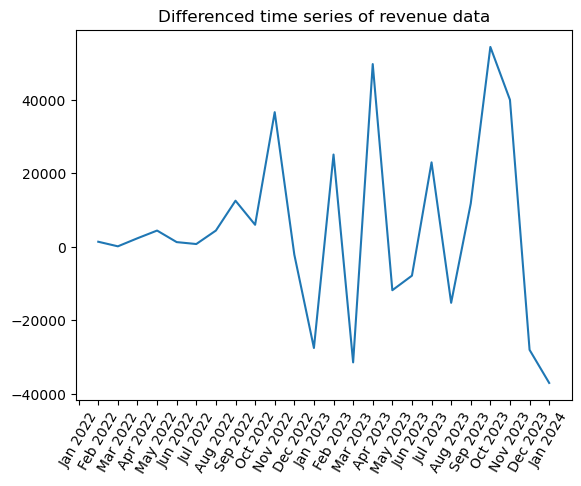

Check stationarity of differenced revenue data
ADF Statistic: -2.916181045905725
p-value: 0.04349845904809723
Stationary


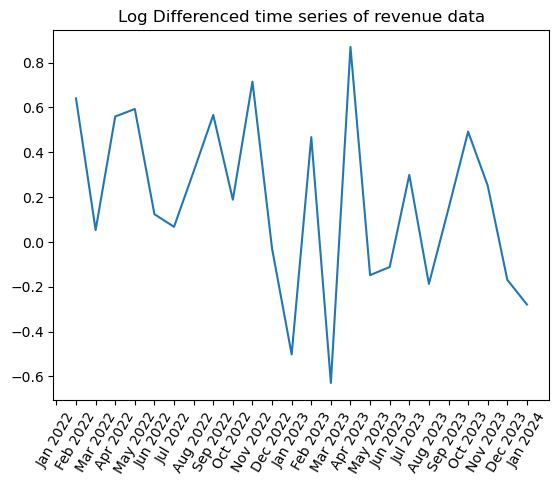

Check stationarity of log-differenced revenue data
ADF Statistic: -6.107513188743693
p-value: 9.50592570315161e-08
Strongly Stationary


In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    if p_value < 0.01:
        print('Strongly Stationary')
    elif p_value<0.05:
        print('Stationary')
    else:
        print('Non-Stationary')
 
print("Check stationarity of overall revenue data")
check_stationarity(yOver)

# Use differncing to turn into a stationary time series
diffyOverall = csvFile["Overall"].astype(float).diff()
plt.plot(xdate, diffyOverall)
plt.title("Differenced time series of revenue data")
plt.xticks(rotation = 60)
plt.show()
print("Check stationarity of differenced revenue data")
check_stationarity(diffyOverall.dropna())

#Use log then differene. This implies an expotential type SARIMA model
diffyOverallLog = np.log(csvFile["Overall"].astype(float).dropna()).diff()
plt.plot(xdate, diffyOverallLog)
plt.title("Log Differenced time series of revenue data")
plt.xticks(rotation = 60)
plt.show()
print("Check stationarity of log-differenced revenue data")
check_stationarity(diffyOverallLog.dropna())

# Check frequency components

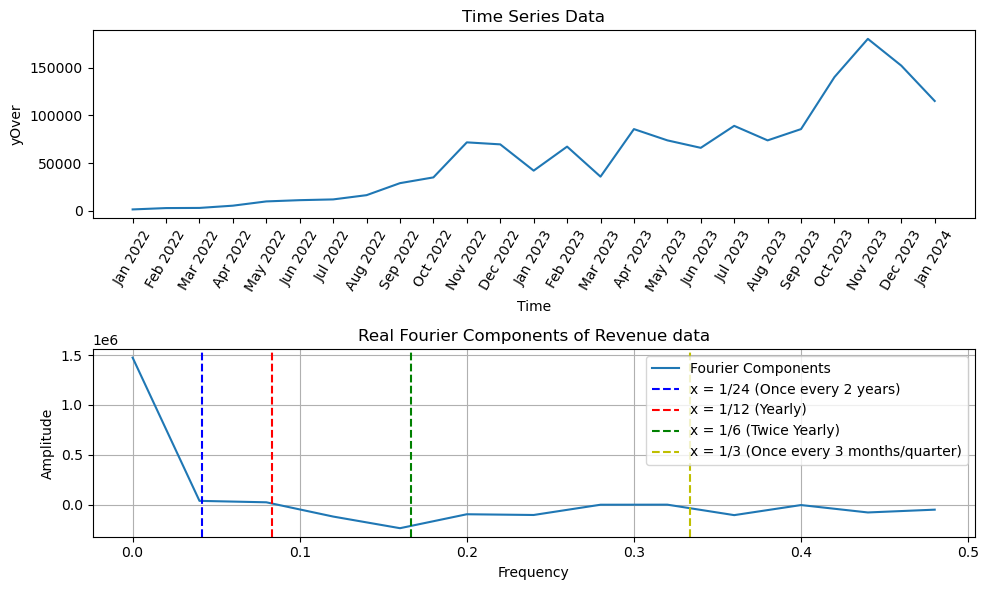

A non null seasonally trend


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft

# Compute the Fourier transform
yOver_rfft = rfft(yOver)

# Compute the frequencies corresponding to the Fourier components
freqs = np.fft.rfftfreq(len(yOver))

# Plot the original time series data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(xdate, yOver, label="Original Data")
plt.xticks(rotation = 60)
plt.xlabel("Time")
plt.ylabel("yOver")
plt.title("Time Series Data")

# Plot the Fourier components
plt.subplot(2, 1, 2)
plt.plot(freqs, np.real(yOver_rfft), label="Fourier Components")
plt.xlabel("Frequency")
plt.axvline(x=1/24, color='b', linestyle='--', label="x = 1/24 (Once every 2 years)")
plt.axvline(x=1/12, color='r', linestyle='--', label="x = 1/12 (Yearly)")
plt.axvline(x=1/6, color='g', linestyle='--', label="x = 1/6 (Twice Yearly)")
plt.axvline(x=1/3, color='y', linestyle='--', label="x = 1/3 (Once every 3 months/quarter)")
plt.legend()
plt.ylabel("Amplitude")
plt.title("Real Fourier Components of Revenue data")
plt.grid()

plt.tight_layout()
plt.show()
print("A non null seasonally trend")

## Fit SARMIA Model

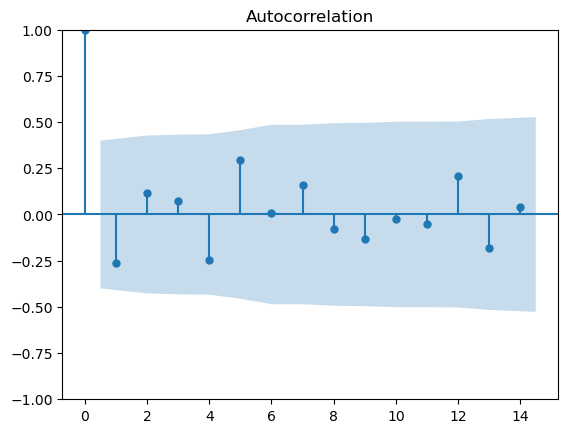

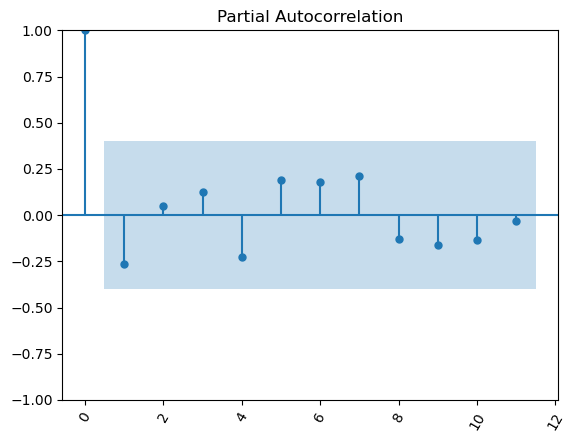

In [47]:
monthly_sales = diffyOverallLog.dropna()

plot_acf(monthly_sales)
plot_pacf(monthly_sales,lags=11)
plt.xticks(rotation = 60)
plt.show()

In [67]:
# Define SARIMA parameters from the graphs above
# For data no SARIMA model fitted well!
p, d, q = 0, 0, 0
P, D, Q, s = 0, 0, 0, 12  # Assuming monthly seasonality
 
# Fit the SARIMA model
model = SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(method_kwargs={'maxiter':30000})
results

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(


# EBITDA Multiples

In [66]:
#Compute a last 12 months average of revenue

averageEBITDA = (yOver[-12:]).mean()

#Find multiple in list
#https://www.equidam.com/ebitda-multiples-trbc-industries/
#Between 6.12 and 13.1

minBusinessVal = 6.12 * averageEBITDA
maxBusinessVal = 13.1 * averageEBITDA

print(minBusinessVal)
maxBusinessVal

593623.4428653


1270664.5590744165

# Fit a Sigmoid Model

## Pure Sigmoid model

Overall Limit parameter (L) 66144.28370819212
Overall Inflection (x0) 8.069083994279683
Overall Scale parameter (k) 0.7057810653996991


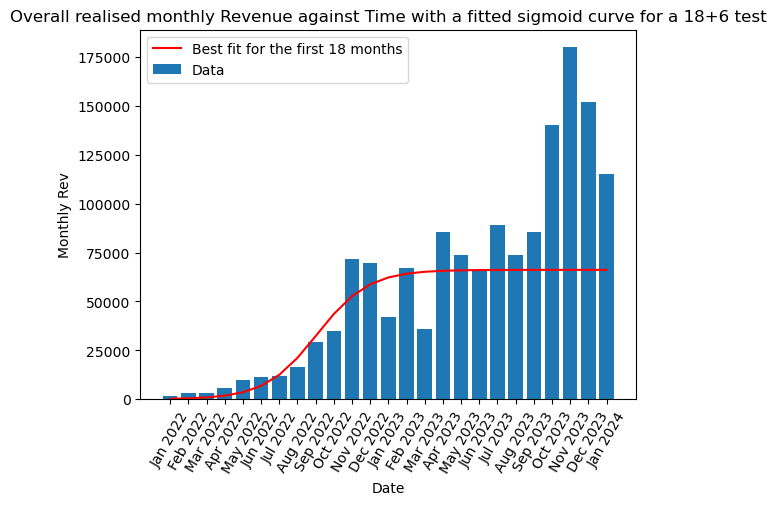

MSE for final 6 months 1655840364.2164671


In [65]:
#
# Do a 18+6 and 20+4 backtest
#

#18+6 back test a sigmoid curve
popt, pcov = curve_fit(sigmoid, xnum[:18], yOver[:18], p0=[50000,24,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Inflection (x0)", popt[1])
print("Overall Scale parameter (k)", popt[2])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, sigmoid(xnum, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 18 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 18+6 test")
plt.show()
print("MSE for final 6 months", np.square(np.subtract(yOver[6:], sigmoid(xnum[6:], popt[0], popt[1], popt[2]))).mean() )

Overall Limit parameter (L) 73251.71754858916
Overall Inflection (x0) 8.562569772716635
Overall Scale parameter (k) 0.49993572015624627


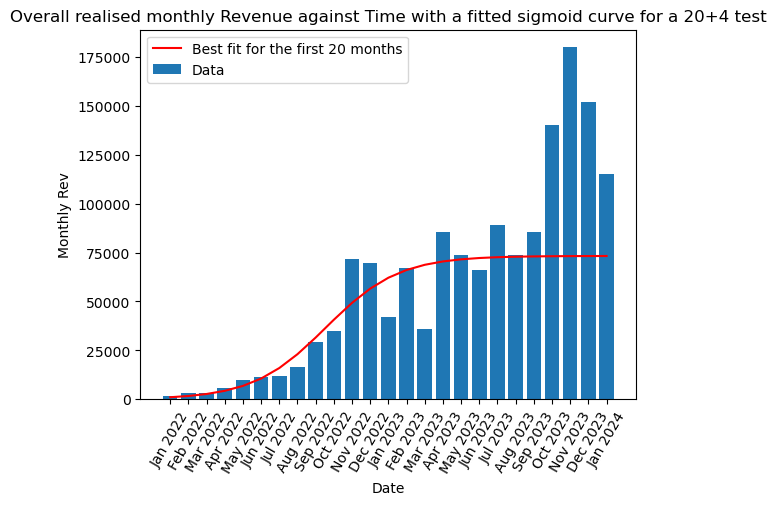

MSE for final 4 months 1276535495.0425208


In [64]:
#20+4 back test a sigmoid curve
popt, pcov = curve_fit(sigmoid, xnum[:20], yOver[:20], p0=[50000,24,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Inflection (x0)", popt[1])
print("Overall Scale parameter (k)", popt[2])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, sigmoid(xnum, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 20 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 20+4 test")
plt.show()
print("MSE for final 4 months", np.square(np.subtract(yOver[4:], sigmoid(xnum[4:], popt[0], popt[1], popt[2]))).mean() )

## Exponential+Sigmoid Model

Overall Limit parameter (L) 11041.782014108343
Overall Scale parameter (k) 0.11984785826634989


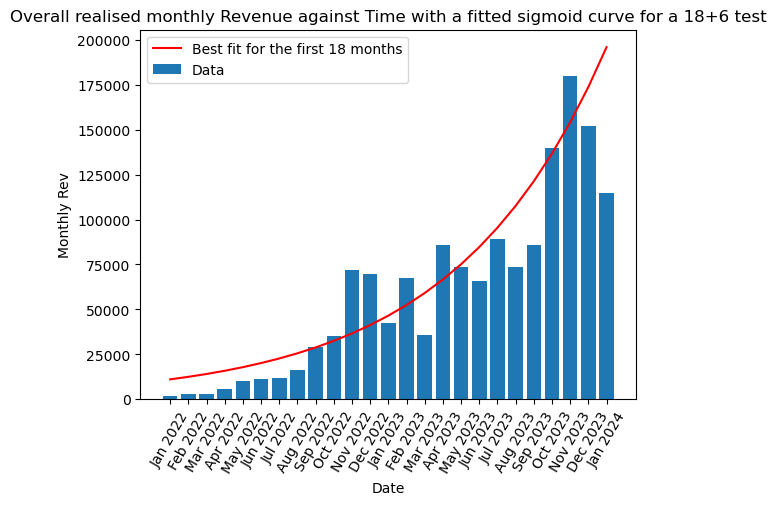

MSE for final 6 months 731932267.659008


In [63]:
#18+6 back test an expo curve
popt, pcov = curve_fit(expo, xnum[:18], yOver[:18], p0=[50000,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Scale parameter (k)", popt[1])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 18 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 18+6 test")
plt.show()
print("MSE for final 6 months", np.square(np.subtract(yOver[6:], expo(xnum[6:], popt[0], popt[1]))).mean() )

Overall Limit parameter (L) 12956.166526123516
Overall Scale parameter (k) 0.10411176483904276


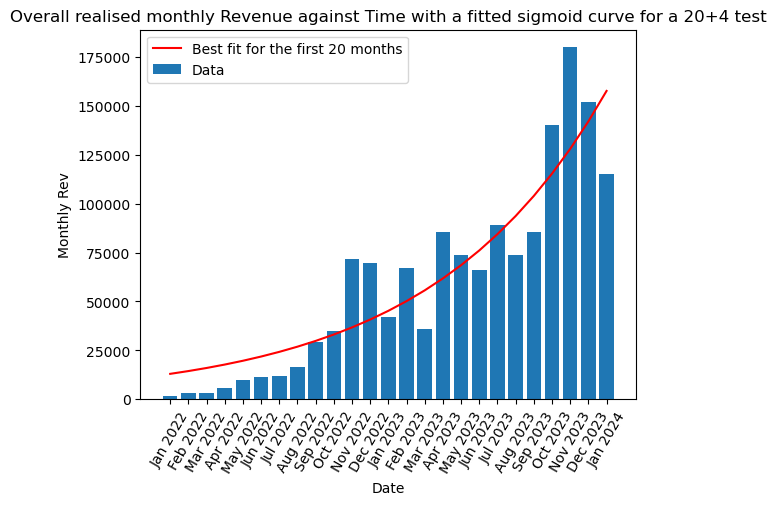

MSE for final 4 months 471432322.7618408


In [62]:
#20+4 back test an expo curve
popt, pcov = curve_fit(expo, xnum[:20], yOver[:20], p0=[50000,0.01] ,method='lm')
print("Overall Limit parameter (L)", popt[0])
print("Overall Scale parameter (k)", popt[1])

plt.bar(xdate, yOver) #Known realised rev. For 18 months
plt.plot(xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit for the first 20 months","Data"])
plt.title("Overall realised monthly Revenue against Time with a fitted sigmoid curve for a 20+4 test")
plt.show()
print("MSE for final 4 months", np.square(np.subtract(yOver[4:], expo(xnum[4:], popt[0], popt[1]))).mean() )

## Fit lowest MSE model

Expo Limit parameter (L) 13724.28260270199
Expo Scale parameter (k) 0.10207452625761901


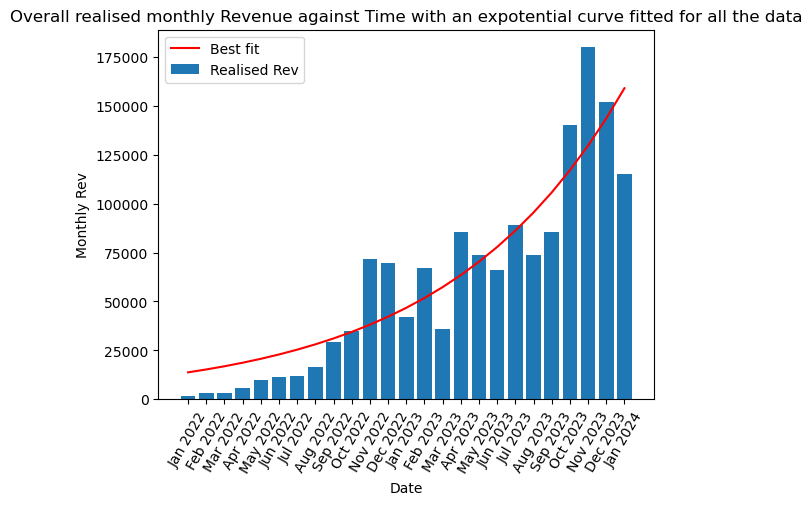

Modified sigmoid Limit parameter (L) 1876262.864726439
Modified sigmoid posiiton (x0) 47.58059238990878


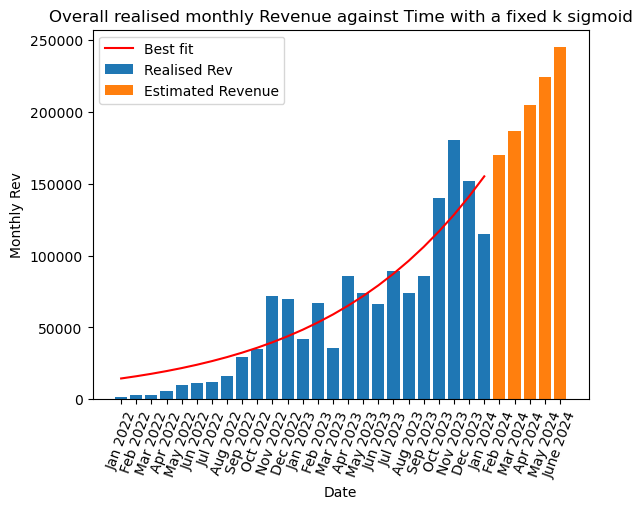

In [32]:
#Curve fit Expo as that had the lowest MSE for the back-tested models
popt, pcov = curve_fit(expo, xnum, yOver, p0=[5000000,0.001] ,method='lm')
print("Expo Limit parameter (L)", popt[0])
print("Expo Scale parameter (k)", popt[1]) #Need to put this in the sigmoidMod function
#Plot the expo data
plt.bar(xdate, yOver) #Known realised rev
plt.plot( xdate, expo(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit", "Realised Rev"])
plt.title("Overall realised monthly Revenue against Time with an expotential curve fitted for all the data")
plt.show()

#
#Use the expo to fit a sigmoid. Sigmoid give bound expotential growth and typically business growth pattern
#

popt, pcov = curve_fit(sigmoidMod, xnum, yOver, p0=[50000000,30] ,method='lm', maxfev=2000)
print("Modified sigmoid Limit parameter (L)", popt[0])
print("Modified sigmoid posiiton (x0)", popt[1])

#Plot predicted data
xx = ['Feb 2024', 'Mar 2024', 'Apr 2024', 'May 2024', 'June 2024'] #Need to fix this data frame creation to make adaptable
xy = []
for i in range(N,N+5):
    xy.append( sigmoidMod(i, popt[0], popt[1]) )

#Plot sigmoid
plt.bar(xdate, yOver) #Known realised rev
xy = np.array(xy)
plt.bar(xx, xy)
plt.plot( xdate, sigmoidMod(xnum, popt[0], popt[1]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 70)
plt.ylabel("Monthly Rev")
plt.legend(["Best fit", "Realised Rev", "Estimated Revenue"])
plt.title("Overall realised monthly Revenue against Time with a fixed k sigmoid")
plt.show()

## DCF Analysis of Modified Sigmoid model

In [61]:
discount = 0.0378/12 #Current yield of a 10-year treasury
years = 3 #Time to IPO/Buyback
value = 0

print("Assume the revenue is the free cashflow. Unknown ITDA!")
for i in range(N,12*years*1):
    value += ( (sigmoidMod(i, popt[0], popt[1])) / pow((1 + discount),i-N) )

print("Using a discounted cash flow model for the next",years,"years with a current annual discount rate of", round(discount*12*100,3),"%")
print("Market cap £", round(value/pow(10,6),3), "Million")
print("Market cap £", round(value/pow(10,9),3), "Billion")
print("Monthly revenue £", round(popt[0],4) )
print("Yearly revenue £", round(12*popt[0],4) )
print("Yearly revenue £", round(12*popt[0]/pow(10,9),1) ,"Billion")
numShares = 5
valueShare = value/numShares
orignal = 354.6
print("")
print("Analysis of shares")
print("Original value of 1 share £", orignal)
print("Number of shares:", numShares)
print("Value of 1 share in DCF model £", round(valueShare,4) )
print("Limiting cash flow value per share £", round(popt[0]/numShares,4) )
percentRaise = (valueShare-orignal)/orignal
print("Percentage return:", round(percentRaise*100,3), "%")
print("Excess return over discount",round( (percentRaise-(12*discount) )*100, 3) ,"%")

Assume the revenue is the free cashflow. Unknown ITDA!
Using a discounted cash flow model for the next 3 years with a current annual discount rate of 3.78 %
Market cap £ 0.61 Million
Market cap £ 0.001 Billion
Monthly revenue £ 66488.5813
Yearly revenue £ 797862.9754
Yearly revenue £ 0.0 Billion

Analysis of shares
Original value of 1 share £ 354.6
Number of shares: 5
Value of 1 share in DCF model £ 121933.5157
Limiting cash flow value per share £ 13297.7163
Percentage return: 34286.214 %
Excess return over discount 34282.434 %


UK Limit parameter (L) 24177.87305963984
UK Inflection (x0) 4.9509931237591385
UK Scale parameter (k) 0.9901023633408902


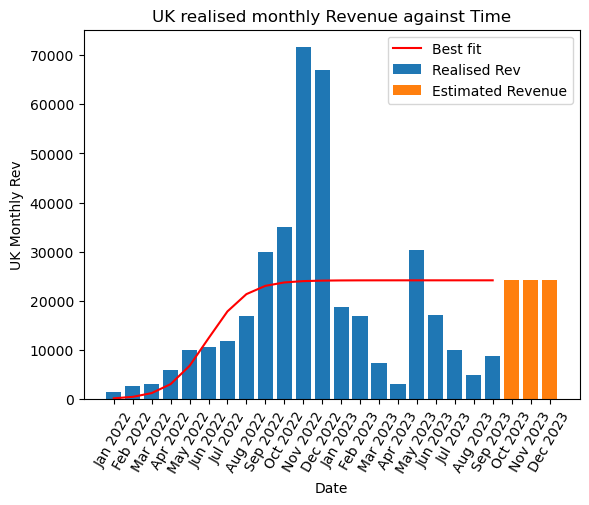


US Limit parameter (L) 66488.58128102208
US Inflection (x0) 12.870580712748264
US Scale parameter (k) 0.8719528877554601


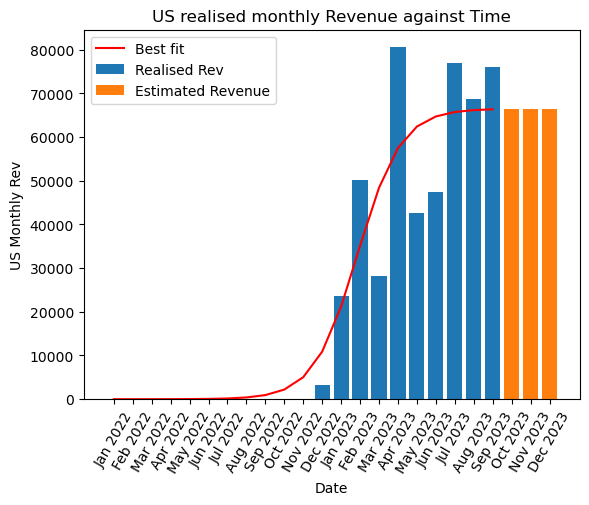

In [34]:
#
# Plot UK and US and predict
#
# UK
popt, pcov = curve_fit(sigmoid, xnum2, yUK, p0=[50000,20,0.01] ,method='lm')
print("UK Limit parameter (L)", popt[0])
print("UK Inflection (x0)", popt[1])
print("UK Scale parameter (k)", popt[2])

#Calculate predicted data
xx = ['Oct 2023', 'Nov 2023', 'Dec 2023']
xy = []
for i in range(N,N+3):
    xy.append( sigmoid(i, popt[0], popt[1], popt[2]) )
#Plot UK
plt.bar(xdate[:N2], yUK)
plt.bar(xx, xy)
plt.plot( xdate[:N2], sigmoid(xnum2, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("UK Monthly Rev")
plt.legend(["Best fit", "Realised Rev", "Estimated Revenue"])
plt.title("UK realised monthly Revenue against Time")
plt.show()
print("")
#US
popt, pcov = curve_fit(sigmoid, xnum2, yUS, p0=[5000000,100,0.001] ,method='lm')
print("US Limit parameter (L)", popt[0])
print("US Inflection (x0)", popt[1])
print("US Scale parameter (k)", popt[2])

#Calculate predicted data
xx = ['Oct 2023', 'Nov 2023', 'Dec 2023']
xy = []
for i in range(N,N+3):
    xy.append( sigmoid(i, popt[0], popt[1], popt[2]) )
#Plot US
plt.bar(xdate[:N2], yUS)
plt.bar(xx, xy)
plt.plot( xdate[:N2], sigmoid(xnum2, popt[0], popt[1], popt[2]) , 'r')
plt.xlabel("Date")
plt.xticks(rotation = 60)
plt.ylabel("US Monthly Rev")
plt.legend(["Best fit", "Realised Rev", "Estimated Revenue"])
plt.title("US realised monthly Revenue against Time")
plt.show()